In [27]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
sns.set(style="whitegrid")

In [29]:
model = joblib.load("../src/model/churn_model.pkl")

In [30]:
df = pd.read_csv("../data/raw/Dataset.csv")

In [31]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

In [32]:
df = df.drop(columns=["customerID"])

In [33]:
df["charge_per_tenure"] = df["MonthlyCharges"] / (df["tenure"] + 1)

In [34]:
services = [
    "OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies"
]

In [35]:
df["num_services"] = (df[services] == "Yes").sum(axis=1)

In [36]:
df["tenure_group"] = pd.cut(
    df["tenure"],
    bins=[0,12,24,48,72],
    labels=["0-1yr","1-2yr","2-4yr","4-6yr"],
    include_lowest=True
)


In [37]:
preprocessor = model.named_steps["preprocessor"]
feature_names = preprocessor.get_feature_names_out()

len(feature_names)


51

In [38]:
log_model = model.named_steps["model"]

In [39]:
coefficients = log_model.coef_[0]

In [40]:
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
}).sort_values(by="Abs_Coefficient", ascending=False)

In [41]:
coef_df.head(15)


,Feature,Coefficient,Abs_Coefficient
40,cat__Contract_Two year,-0.933666,0.933666
2,num__MonthlyCharges,-0.815810,0.815810
38,cat__Contract_Month-to-month,0.765772,0.765772
1,num__tenure,-0.758109,0.758109
18,cat__InternetService_Fiber optic,0.727183,0.727183
17,cat__InternetService_DSL,-0.668054,0.668054
4,num__charge_per_tenure,0.336208,0.336208
3,num__TotalCharges,0.303423,0.303423
5,num__num_services,0.262465,0.262465
41,cat__PaperlessBilling_No,-0.262339,0.262339


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16176\3178814706.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


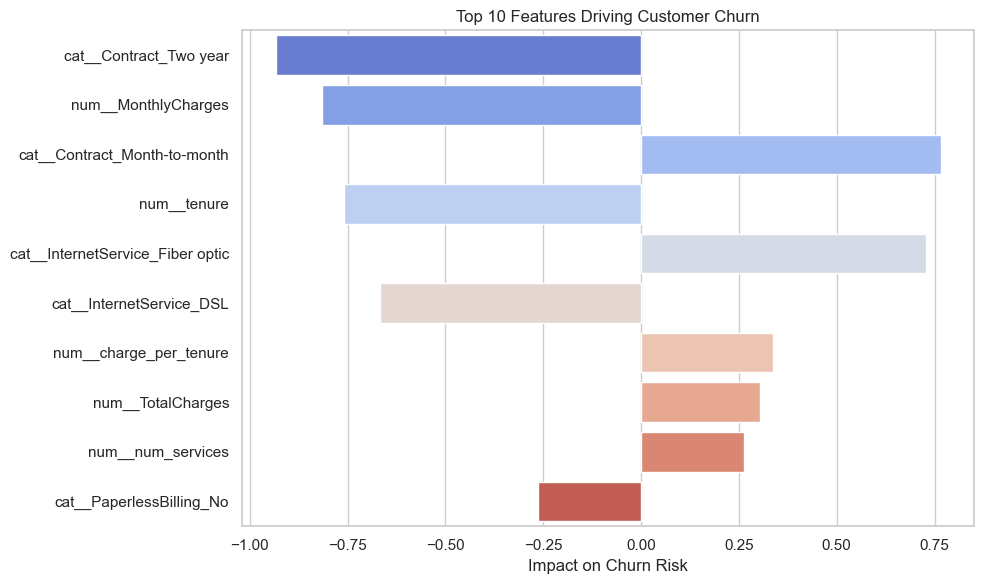

In [42]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=coef_df.head(10),
    x="Coefficient",
    y="Feature",
    palette="coolwarm"
)
plt.title("Top 10 Features Driving Customer Churn")
plt.xlabel("Impact on Churn Risk")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [43]:
def map_to_business_driver(feature):
    if "tenure" in feature:
        return "Customer Lifecycle"
    elif "MonthlyCharges" in feature or "charge_per_tenure" in feature:
        return "Pricing Pressure"
    elif "Contract" in feature:
        return "Contract Commitment"
    elif "TechSupport" in feature or "OnlineSecurity" in feature:
        return "Support & Service Quality"
    elif "Streaming" in feature:
        return "Entertainment Services"
    elif "PaymentMethod" in feature:
        return "Payment Behavior"
    elif "num_services" in feature:
        return "Service Adoption"
    else:
        return "Other"

coef_df["Business_Driver"] = coef_df["Feature"].apply(map_to_business_driver)


BUSINESS DRIVER PLOT

In [44]:
business_importance = (
    coef_df
    .groupby("Business_Driver")["Abs_Coefficient"]
    .sum()
    .sort_values(ascending=False)
)

business_importance


Business_Driver
Other                        4.356099
Contract Commitment          1.711157
Customer Lifecycle           1.435122
Entertainment Services       1.242909
Support & Service Quality    1.176663
Pricing Pressure             0.815810
Payment Behavior             0.630627
Service Adoption             0.262465
Name: Abs_Coefficient, dtype: float64

CUSTOMER-LEVEL REASONING (RULE-BASED)

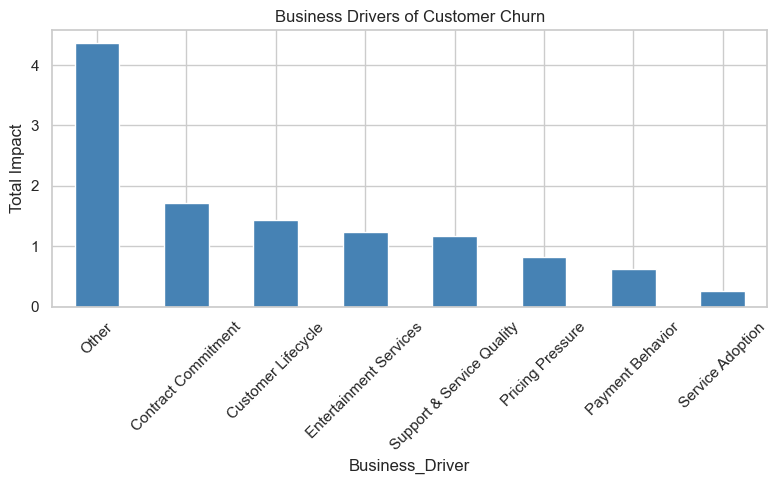

In [45]:
plt.figure(figsize=(8,5))
business_importance.plot(kind="bar", color="steelblue")
plt.title("Business Drivers of Customer Churn")
plt.ylabel("Total Impact")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [46]:
def explain_customer(row):
    reasons = []

    if row["tenure"] < 12:
        reasons.append("Customer is new (low tenure)")

    if row["MonthlyCharges"] > 80:
        reasons.append("High monthly charges")

    if row["Contract"] == "Month-to-month":
        reasons.append("No long-term contract")

    if row["TechSupport"] == "No":
        reasons.append("No technical support")

    if row["num_services"] <= 1:
        reasons.append("Low service adoption")

    return reasons


In [47]:
sample_customer = df.sample(1, random_state=42).iloc[0]
explain_customer(sample_customer)


['Customer is new (low tenure)',
 'No long-term contract',
 'No technical support',
 'Low service adoption']

In [48]:
df["Predicted_Churn_Prob"] = model.predict_proba(df.drop(columns=["Churn"]))[:, 1]

df["Revenue_At_Risk"] = df["Predicted_Churn_Prob"] * df["MonthlyCharges"] * 6


In [49]:
total_revenue_risk = df["Revenue_At_Risk"].sum()
total_revenue_risk


np.float64(1271589.6073555215)

In [50]:
total_risk = df["Revenue_At_Risk"].sum()
total_risk


np.float64(1271589.6073555215)

In [51]:
df.groupby("Contract")["Revenue_At_Risk"].sum().sort_values(ascending=False)


Contract
Month-to-month    1.042892e+06
One year          1.677149e+05
Two year          6.098276e+04
Name: Revenue_At_Risk, dtype: float64

In [52]:
df.groupby("PaymentMethod")["Revenue_At_Risk"].sum().sort_values(ascending=False)


PaymentMethod
Electronic check             712766.391096
Bank transfer (automatic)    203094.482271
Credit card (automatic)      189889.797285
Mailed check                 165838.936703
Name: Revenue_At_Risk, dtype: float64

Key Findings:

New customers churn more

Month-to-month contracts are highest risk

High pricing increases churn probability

Support services reduce churn

Electronic check users show higher risk

Recommended Actions:

Incentivize long-term contracts

Provide early-tenure engagement offers

Bundle services to increase adoption

Target high-risk payment methods